In [1]:
#Resume Analyser Project - Interview Preparation [Prajval Yelpale]

In [ ]:
#Installing required packages:

!pip install resume-parser
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
!pip install importlib-metadata==3.2.0

In [ ]:
import nltk
import spacy

!pip install fuzzywuzzy
!python -m spacy download en_core_web_sm
!python -m nltk.downloader stopwords
!python -m nltk.downloader averaged_perceptron_tagger
!python -m nltk.downloader punkt
!python -m nltk.downloader universal_tagset
!python -m nltk.downloader wordnet
!python -m nltk.downloader brown
!python -m nltk.downloader maxent_ne_chunker

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [69]:
##### Data preprocessing: Dataset cleaning

import pandas as pd

resumeDataSet = pd.read_csv(r'/content/ResumeDataset.csv',encoding='utf-8')

import re

def clean_skills(skill_str):
    # Adjust regular expression to match multi-word phrases within double quotes
    cleaned_skills = re.findall(r'"([\w\s.-]+)"|[\w-]+', skill_str)
    cleaned_skills = ["'" + skill.strip('\"') + "'" if '"' in skill else skill.strip() for skill in cleaned_skills]
    # Join the cleaned skills into a single string and remove empty values
    cleaned_str = ', '.join(skill for skill in cleaned_skills if skill)
    skills_str = resumeDataSet['Skills_Or_Keywords'][0]

    # Split the skills into a list based on commas
    skills_list = cleaned_str.split(", ")

    return skills_list


resumeDataSet['Skills_Or_Keywords'] = resumeDataSet.Skills_Or_Keywords.apply(lambda x: clean_skills(x))


resumeDataSet.head()


,Category,Skills_Or_Keywords
0,Web Development,"[HTML, CSS, JavaScript, React.js, Angular, Vue..."
1,Mobile App Development,"[iOS Development, Android Development, Swift, ..."
2,Data Science,"[Python, Machine Learning, Data Analysis, Stat..."
3,Machine Learning,"[Python, Machine Learning, Data Science, Deep ..."
4,Artificial Intelligence,"[Machine Learning, Deep Learning, Computer Vis..."


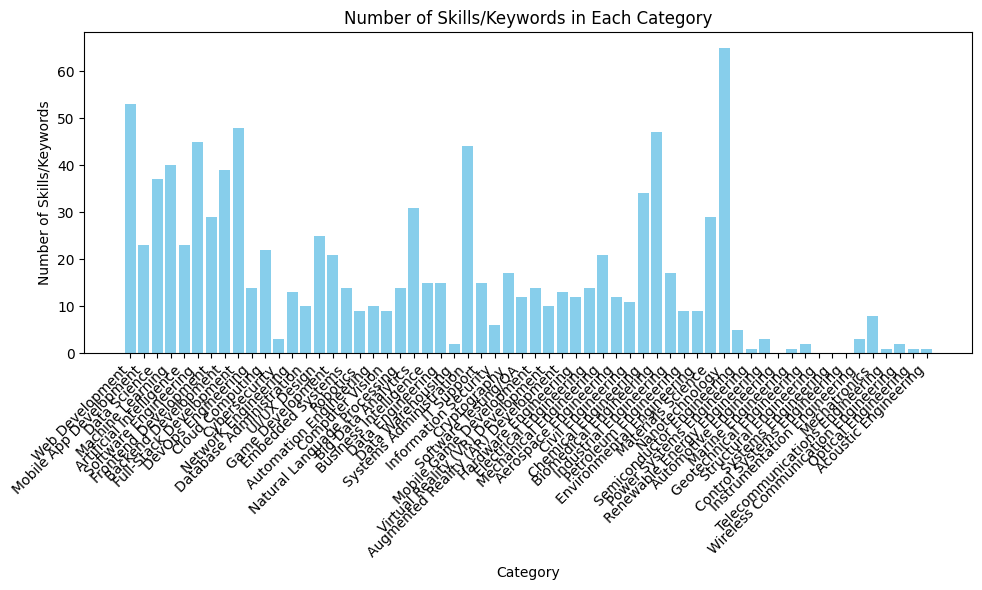

In [106]:
##### Data Visualization #####

df=resumeDataSet

# Calculate the number of skills in each category
df['Num_Skills'] = df['Skills_Or_Keywords'].apply(len)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df['Category'], df['Num_Skills'], color='skyblue')
plt.title('Number of Skills/Keywords in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Skills/Keywords')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# This is Resume parsing model (Internal traning included) (Read Documentation)

from resume_parser import resumeparse

In [113]:
##### Parsing Users Resume Data #####

import pprint
data = resumeparse.read_file(r'/content/Data_science.pdf')
pprint.pprint(data)

{'Companies worked at': [],
 'degree': ['PhD in Physics and 1', '©', 'PhD'],
 'designition': ['data scientist', 'scientist'],
 'email': 'info@qwikresume.com',
 'name': 'Data Scientist',
 'phone': '',
 'skills': ['Data Mining',
            ' Data Analysis',
            ' Machine Learning',
            ' Python',
            ' R',
            ' MATLAB',
            ' Sphinx',
            ' LaTeX',
            ' Mathematica',
            '',
            'Maple',
            ' GIT',
            ' CVS',
            ' HTCondor.'],
 'total_exp': 12,
 'university': []}


In [109]:
##### This is function to clean and normalize the skills parsed from users resume #####

def normalize_keyword(keyword):
    # Convert to lowercase
    keyword = keyword.lower()
    # Replace non-alphanumeric characters (except spaces and hyphens) with spaces
    keyword = re.sub(r'[^a-z0-9 -]', ' ', keyword)
    # Remove extra spaces
    keyword = re.sub(r'\s+', ' ', keyword).strip()
    return keyword


def extract_keywords(skill_text):
    # Normalize and split into individual keywords
    normalized_text = normalize_keyword(skill_text)
    return normalized_text.split()  # Split into individual skills

user_skills = []
for skill_text in data['skills']:
    extracted_skills = extract_keywords(skill_text)  # Extract normalized skills
    user_skills.extend(extracted_skills)  # Add to the list of all skills

print(user_skills)

['data', 'mining', 'data', 'analysis', 'machine', 'learning', 'python', 'r', 'matlab', 'sphinx', 'latex', 'mathematica', 'maple', 'git', 'cvs', 'htcondor']


In [110]:
### Resume category prediction using Machine Learning ###

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample data (replace with your actual dataset)
data = resumeDataSet
# Preprocess text (lowercase, remove punctuation and stopwords)
def preprocess_text(text):
  stop_words = ["i", "a", "an", "the", "of", "to", "in", "for", "on", "with", "at", "by", "is", "are", "was", "were", "be", "been", "has", "have", "it", "its", "that", "which", "what", "these", "those", "this", "or", "but", "up", "will", "all", "my", "we", "our", "make", "about", "get", "one", "there", "would", "their", "if", "el", "and", "from", "ent", "com", "org", "uk", "net", "io", "www"]  # Add more stopwords as needed
  return [word.lower() for word in text if word.isalnum() and word not in stop_words]

data['Skills_Or_Keywords'] = [preprocess_text(skills) for skills in data['Skills_Or_Keywords']]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Fit the vectorizer on the skills data
tfidf_matrix = vectorizer.fit_transform([", ".join(skills) for skills in data['Skills_Or_Keywords']])

# Define a function to find most similar categories
def find_most_similar(user_skills, top_n=1):
  user_skills_vector = vectorizer.transform([" ".join(user_skills)])
  similarities = cosine_similarity(user_skills_vector, tfidf_matrix)
  # Get the index of the maximum similarity
  most_similar_idx = similarities.argmax(axis=1)[0]
  return data['Category'][most_similar_idx],most_similar_idx

# Example usage
predicted_category,predicted_index = find_most_similar(user_skills)

print("Predicted Category of resume: ", predicted_category)
print("Skills and Keywords: ",resumeDataSet['Skills_Or_Keywords'][predicted_index])

Predicted Category of resume:  Data Engineering
Skills and Keywords:  ['sql', 'python', 'hadoop', 'nosql', 'newsql', 'azure', 'docker', 'kubernetes', 'devops', 'linux', 'scrum', 'kanban', 'collaboration', 'communication', 'git']


In [111]:
from fuzzywuzzy import fuzz

def recommend_skills(user_skills, dataset_skills):

  recommended_skills = []
  for skill in dataset_skills:
    # Lowercase both skill and user skills for case-insensitive matching
    lower_skill = skill.lower()
    if not any(fuzz.ratio(user_skill.lower(), lower_skill) > 80 for user_skill in user_skills):
      recommended_skills.append(lower_skill)
      if len(recommended_skills) == 7:
        break

  return recommended_skills

recommended_skills = recommend_skills(user_skills, resumeDataSet['Skills_Or_Keywords'][predicted_index])

print("Recommended Skills:")
for skill in recommended_skills:
  print(skill)

Recommended Skills:
sql
hadoop
nosql
newsql
azure
docker
kubernetes


In [114]:
##### This is algorithm to calculate the resume score #####
import re
from fuzzywuzzy import fuzz

def normalize_text(text):
  return re.sub(r'[^\w\s]', '', text.strip().lower())

def calculate_resume_score(resume_data, dataset_skills, weight_factors):

  # Normalize skills
  resume_skills = {normalize_text(skill) for skill in resume_data.get("Skills", []) if skill.strip()}

  # Normalize dataset skills and create lookup dictionary
  normalized_dataset_skills = {normalize_text(skill): i for i, skill in enumerate(dataset_skills)}

  # Calculate skill relevance score
  matching_skills = [normalized_dataset_skills[skill] for skill in resume_skills if skill in normalized_dataset_skills]
  skill_count = len(matching_skills)

  if skill_count == 0:
    skill_relevance_score = 0
  else:
    # Consider weighted average of normalized skill positions in dataset
    weighted_total = sum([(len(dataset_skills) - pos) for pos in matching_skills])
    max_weighted_total = sum(range(len(dataset_skills), 0, -1))
    skill_relevance_score = (weighted_total / max_weighted_total) * 100 * weight_factors["skills"]

  # Calculate experience score
  total_experience = resume_data.get("total_exp", 0)
  max_experience = 20  # Adjust as needed
  experience_score = min(total_experience / max_experience, 1) * 100 * weight_factors["experience"]

  # Calculate education score with fuzzy matching for degree types
  degrees = [normalize_text(degree) for degree in resume_data.get("degree", []) if degree.strip()]
  degree_score = 0  # Base score

  for degree in degrees:
    # Use fuzz.token_sort_ratio for better matching with variations
    if fuzz.token_sort_ratio(degree, "phd") > 80:
      degree_score = 100
      break
    elif fuzz.token_sort_ratio(degree, "masters") > 80 or fuzz.token_sort_ratio(degree, "msc") > 80:
      degree_score = 70
      break
    elif fuzz.token_sort_ratio(degree, "bachelors") > 80 or fuzz.token_sort_ratio(degree, "bsc") > 80:
      degree_score = 50
      break

  degree_score *= weight_factors["education"]

  # Optional: Calculate company score based on reputation
  # (requires external company reputation data)
  company_reputation_score = 0  # Placeholder for future implementation
  company_score = company_reputation_score * weight_factors["companies"]

  # Total score (out of 100)
  total_score = (
      skill_relevance_score + experience_score + degree_score + company_score
  )
  total_score = min(total_score, 100)  # Cap at 100

  return round(total_score, 2)


# Adjusted weight factors
weight_factors = {
    "skills": 0.4,  # Skills have a higher weight
    "experience": 0.3,
    "education": 0.2,
    "companies": 0.1,
}

# Sample data for testing
resume_data = {
    "Skills": user_skills,
    "total_exp": data['total_exp'],
    "degree": data['degree'],
    "Companies worked at": data['Companies worked at'],
}

skill_dataset=resumeDataSet['Skills_Or_Keywords'][predicted_index]

# Calculate the resume score
resume_score = calculate_resume_score(resume_data, skill_dataset , weight_factors)
print("Your Resume Score is :", resume_score, "out of 100")


Your Resume Score is : 43.0 out of 100


In [67]:
##### Course Recommendation System #####

In [115]:
!pip install neattext
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel

In [118]:
import neattext.functions as nfx

df = pd.read_csv("/content/coursera.csv")

df.head()

,Course Name,University,Difficulty Level,Course Rating,Course URL,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


In [119]:
# Clean Text:stopwords,special charac
df['Course Name'] = df['Course Name'].astype(str)  # Convert non-string values to strings
df['clean_course_title'] = df['Course Name'].apply(nfx.remove_stopwords)

# Clean Text:stopwords,special charac
df['clean_course_title'] = df['clean_course_title'].apply(nfx.remove_special_characters)

df[['Course Name','clean_course_title']]

,Course Name,clean_course_title
0,Write A Feature Length Screenplay For Film Or ...,Write Feature Length Screenplay Film Television
1,Business Strategy: Business Model Canvas Analy...,Business Strategy Business Model Canvas Analys...
2,Silicon Thin Film Solar Cells,Silicon Thin Film Solar Cells
3,Finance for Managers,Finance Managers
4,Retrieve Data using Single-Table SQL Queries,Retrieve Data SingleTable SQL Queries
...,...,...
3517,"Capstone: Retrieving, Processing, and Visualiz...",Capstone Retrieving Processing Visualizing Dat...
3518,Patrick Henry: Forgotten Founder,Patrick Henry Forgotten Founder
3519,Business intelligence and data analytics: Gene...,Business intelligence data analytics Generate ...
3520,Rigid Body Dynamics,Rigid Body Dynamics


In [120]:
# Vectorize our Text
count_vect = CountVectorizer()
cv_mat = count_vect.fit_transform(df['clean_course_title'])

# Sparse
cv_mat

# Dense
cv_mat.todense()

df_cv_words = pd.DataFrame(cv_mat.todense(),columns=count_vect.get_feature_names_out())


In [121]:
# Cosine Similarity Matrix
cosine_sim_mat = cosine_similarity(cv_mat)

cosine_sim_mat

array([[1.        , 0.        , 0.18257419, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.27216553, 0.        ,
        0.        ],
       [0.18257419, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.27216553, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [122]:
# Get Course ID/Index
course_indices = pd.Series(df.index,index=df['Course Name']).drop_duplicates()

course_indices

Course Name
Write A Feature Length Screenplay For Film Or Television                 0
Business Strategy: Business Model Canvas Analysis with Miro              1
Silicon Thin Film Solar Cells                                            2
Finance for Managers                                                     3
Retrieve Data using Single-Table SQL Queries                             4
                                                                      ... 
Capstone: Retrieving, Processing, and Visualizing Data with Python    3517
Patrick Henry: Forgotten Founder                                      3518
Business intelligence and data analytics: Generate insights           3519
Rigid Body Dynamics                                                   3520
Architecting with Google Kubernetes Engine: Production                3521
Length: 3522, dtype: int64

In [123]:
idx = course_indices['Cryptography and Information Theory']

scores = list(enumerate(cosine_sim_mat[idx]))

# Sort our scores per cosine score
sorted_scores = sorted(scores,key=lambda x:x[1],reverse=True)

# Omit the First Value/itself
sorted_scores[1:]

[(1635, 0.816496580927726),
 (3171, 0.6666666666666669),
 (1332, 0.5773502691896258),
 (2946, 0.5773502691896258),
 (1168, 0.408248290463863),
 (1169, 0.408248290463863),
 (1367, 0.408248290463863),
 (37, 0.3333333333333334),
 (341, 0.3333333333333334),
 (717, 0.3333333333333334),
 (1036, 0.3333333333333334),
 (1246, 0.3333333333333334),
 (1560, 0.3333333333333334),
 (1883, 0.3333333333333334),
 (2017, 0.3333333333333334),
 (2097, 0.3333333333333334),
 (2100, 0.3333333333333334),
 (2351, 0.3333333333333334),
 (2597, 0.3333333333333334),
 (3303, 0.3333333333333334),
 (386, 0.2886751345948129),
 (660, 0.2886751345948129),
 (667, 0.2886751345948129),
 (1014, 0.2886751345948129),
 (1316, 0.2886751345948129),
 (1488, 0.2886751345948129),
 (1917, 0.2886751345948129),
 (2036, 0.2886751345948129),
 (2037, 0.2886751345948129),
 (2603, 0.2886751345948129),
 (3195, 0.2886751345948129),
 (117, 0.25819888974716115),
 (361, 0.25819888974716115),
 (1091, 0.25819888974716115),
 (1150, 0.25819888974716

In [124]:
# Selected Courses Scores
selected_course_scores = [i[1] for i in sorted_scores[1:]]

selected_course_indices = [i[0] for i in sorted_scores[1:]]

recommended_result = df['Course Name'].iloc[selected_course_indices]


rec_df = pd.DataFrame(recommended_result)

rec_df.head()

,Course Name
1635,Information Theory
3171,Number Theory and Cryptography
1332,Cryptography
2946,Cryptography
1168,Symmetric Cryptography


In [125]:
def recommend_course(keywords, num_of_rec=10):
    # Convert the list of words to a space-separated string
    query = ' '.join(keywords)

    # Use TfidfVectorizer to transform the query and courses into vectors
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([query] + df['Course Description'].tolist())

    # Calculate cosine similarity between the query and all courses
    cosine_similarities = cosine_similarity(vectors[0], vectors[1:]).flatten()

    # Get indices of courses sorted by similarity
    sorted_indices = cosine_similarities.argsort()[::-1]

    # Select top recommendations
    selected_course_indices = sorted_indices[1:num_of_rec + 1]
    selected_course_scores = cosine_similarities[selected_course_indices]

    # Create a DataFrame with recommended courses and their similarity scores
    result = df['Course Name'].iloc[selected_course_indices]
    rec_df = pd.DataFrame(result)
    rec_df['similarity_scores'] = selected_course_scores

    return rec_df


In [126]:
print("Coursera courses recommended for users: ")
recommend_course(recommended_skills,10)

Coursera courses recommended for users: 


,Course Name,similarity_scores
2719,Getting Started with Azure,0.263176
3282,Getting Started with Google Kubernetes Engine,0.247936
879,Docker Essentials & Building a Containerized W...,0.241543
3184,Fundamentals of Kubernetes Deployment,0.208271
2789,Containerization Using Docker,0.206813
3156,NoSQL systems,0.203879
2563,Deep Learning Inference with Azure ML Studio,0.183612
3117,Azure Infrastructure Fundamentals,0.180986
1448,Architecting with Google Kubernetes Engine: Fo...,0.172360
1337,Containerize a full-stack NodeJS application i...,0.167275
